In [13]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [14]:
rng = np.random.default_rng()

In [64]:
def simulate_dataset_custom(name, interaction_values, gene_values, cells=1000, rate=1, runs=1, tqdm_disable=True):
    '''
    Custom dataset simulation
    '''

    # number of pairs
    gene_pairs = len(interaction_values) * len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for int_val in tqdm.tqdm(interaction_values, disable=tqdm_disable):
        for gene_val in gene_values:
            for k in range(runs):

                # Set reaction rate parameters
                k_on_1 = gene_val
                k_on_2 = gene_val
                k_off_1 = 1 - gene_val
                k_off_2 = 1 - gene_val
                k_tx_1 = rate
                k_tx_2 = rate
                k_deg_1 = 1
                k_deg_2 = 1
                k_reg = int_val

                # store parameters
                params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

                params = {
                    'k_on_1': k_on_1,
                    'k_on_2': k_on_2,
                    'k_off_1': k_off_1,
                    'k_off_2': k_off_2,
                    'k_tx_1': k_tx_1,
                    'k_tx_2': k_tx_2,
                    'k_deg_1': k_deg_1,
                    'k_deg_2': k_deg_2,
                    'k_reg': k_reg
                }

                # simulate sample from model
                sample = simulation.gillespie_telegraph(params, cells)

                # store counts
                counts_df.iloc[i] = sample

                # increment sample
                i += 1

    # construct dataset object
    data = dataset.Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [65]:
# settings
gene_values = [1.0, 0.75, 0.5, 0.25, 0.1]#[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
intr_values = [0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0] #[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
rate = 5
runs = 5

In [66]:
data = simulate_dataset_custom("data", intr_values, gene_values, cells=1000, rate=rate, runs=runs, tqdm_disable=False)

100%|██████████| 9/9 [09:09<00:00, 61.03s/it]


100%|██████████| 225/225 [00:03<00:00, 60.84it/s]


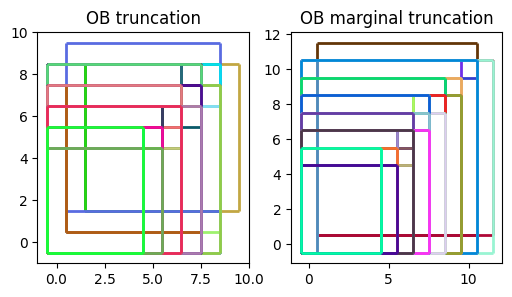

100%|██████████| 96/96 [00:00<00:00, 4375.43it/s]


In [67]:
# pre-process
data.compute_moments(tqdm_disable=False)
data.compute_probabilities(tqdm_disable=False, display=True)

In [68]:
# correlation
corr = correlation.Correlation(
    data,
    tqdm_disable=False,
    printing=False
)

# BD prob
prob_BD = optimization.Optimization(
    data,
    ["marginal_probability", "marginal_CME", "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

# BD moment
momt_BD = optimization.Optimization(
    data,
    ["moment", "marginal_CME", "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

# TE prob
prob_TE = optimization.Optimization(
    data,
    ["marginal_probability", "marginal_CME_TE", "TE_equality" "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

# TE moment
momt_TE = optimization.Optimization(
    data,
    ["moment", "marginal_CME_TE", "TE_equality" "base"],
    license_file="D:/WLS_credentials.json",
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 225/225 [00:04<00:00, 47.35it/s]


In [69]:
# shape
shape = (len(intr_values), len(gene_values))

# arrays for result objects
corr_array = np.zeros(shape)
prob_BD_array = np.zeros(shape)
momt_BD_array = np.zeros(shape)
prob_TE_array = np.zeros(shape)
momt_TE_array = np.zeros(shape)

# sample counter
i = 0

# for each sample
for j, _ in enumerate(intr_values):
    for k, _ in enumerate(gene_values):
        for l in range(runs):

            # get result
            if corr.result_dict[i]['pvalue'] < 0.05:
                corr_array[j, k] += 1 / runs
            if prob_BD.result_dict[i]['status'] == "INFEASIBLE":
                prob_BD_array[j, k] += 1 / runs
            if momt_BD.result_dict[i]['status'] == "INFEASIBLE":
                momt_BD_array[j, k] += 1 / runs
            if prob_TE.result_dict[i]['status'] == "INFEASIBLE":
                prob_TE_array[j, k] += 1 / runs
            if momt_TE.result_dict[i]['status'] == "INFEASIBLE":
                momt_TE_array[j, k] += 1 / runs

            # increment counter
            i += 1

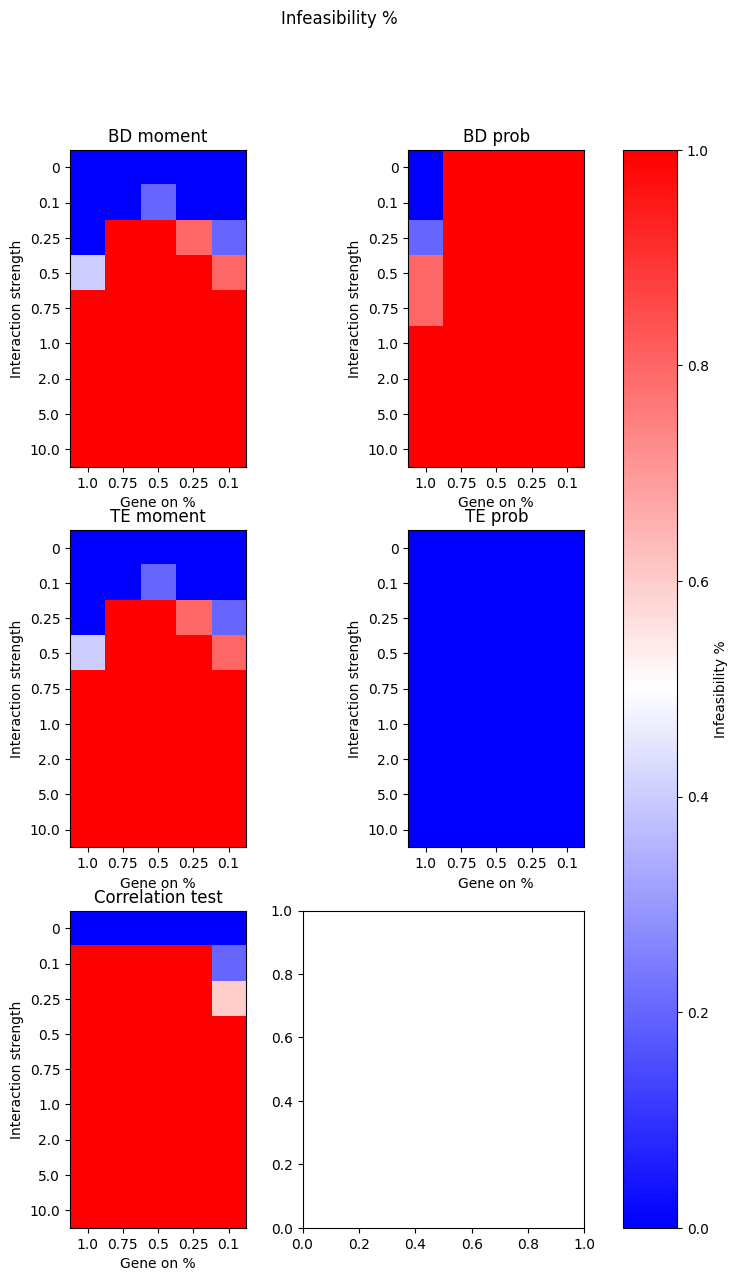

In [74]:
fig, axs = plt.subplots(3, 2, figsize=(10, 14))

fig.suptitle("Infeasibility %")

#plt.tight_layout()

cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

vmin, vmax = 0, 1

def image(idx, result, title):
    img = axs[idx].imshow(result, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[idx].set_xlabel("Gene on %")
    axs[idx].set_xticks(range(len(gene_values)))
    axs[idx].set_xticklabels(gene_values)
    axs[idx].set_ylabel("Interaction strength")
    axs[idx].set_yticks(range(len(intr_values)))
    axs[idx].set_yticklabels(intr_values)
    axs[idx].set_title(title)
    return img

img_momt_BD = image((0, 0), momt_BD_array, "BD moment")
img_prob_BD = image((0, 1), prob_BD_array, "BD prob")
img_momt_TE = image((1, 0), momt_TE_array, "TE moment")
img_prob_TE = image((1, 1), prob_TE_array, "TE prob")

img_corr = image((2, 0), corr_array, "Correlation test")

cbar = plt.colorbar(img_momt_BD, ax=axs)
cbar.set_label("Infeasibility %")